In [1]:
import functools
import gymnasium as gym
import seaborn as sns
from stable_baselines3 import PPO
import torch
import numpy as np
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv
import os
import multiprocessing
from enum import Enum
import json
import wandb
from datetime import datetime
from torch import FloatTensor
from torch.utils.data import DataLoader
import shutil
from models.gail import GAIL
from generate_expert_data import collect_expert_data, postprocess
from forward_simulation import make_configure_env, append_key_to_dict_of_dict, simulate_with_model
from sb3_callbacks import CustomCheckpointCallback, CustomMetricsCallback, CustomCurriculamCallback
from utilities import extract_post_processed_expert_data, write_module_hierarchy_to_file, DefaultActorCriticPolicy, CustomDataset, CustomExtractor, retrieve_gail_agents
import warnings
from imitation.algorithms import bc
from python_config import sweep_config, env_kwargs
import matplotlib.pyplot as plt
import zipfile
from imitation.algorithms import bc
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [5]:
!pip install highway_env

In [11]:
warnings.filterwarnings("ignore")

from highway_env.envs.common.action import DiscreteMetaAction
ACTIONS_ALL = DiscreteMetaAction.ACTIONS_ALL


class TrainEnum(Enum):
    RLTRAIN = 0
    RLDEPLOY = 1
    IRLTRAIN = 2
    IRLDEPLOY = 3
    EXPERT_DATA_COLLECTION =4
    BC = 5
    BCDEPLOY = 6

train = TrainEnum.BC



attention_network_kwargs = dict(
    # in_size=5*15,
    embedding_layer_kwargs={"in_size": 7, "layer_sizes": [64, 64], "reshape": False},
    attention_layer_kwargs={"feature_size": 64, "heads": 2},
    # num_layers = 3,
)

def timenow():
    return datetime.now().strftime("%H%M")

# ==================================
#        Main script  20 
# ==================================


In [8]:
policy_kwargs = dict(
        features_extractor_class=CustomExtractor,
        features_extractor_kwargs=attention_network_kwargs,
    )

if False:
    optimal_gail_agent, final_gail_agent = retrieve_gail_agents(
                                                                # env= make_configure_env(**env_kwargs).unwrapped, # need only certain parameters
                                                                artifact_version='trained_model_directory:v2'
                                                                )
    reward_oracle = final_gail_agent.d
    env_kwargs.update({'reward_oracle':reward_oracle})

WARM_START = False
# Get the current date and time
now = datetime.now()
month = now.strftime("%m")
day = now.strftime("%d")
expert_data_file='expert_data_relative.h5'
validation_data_file = 'expert_data_rel_val.h5'
zip_filename = '../expert_data.zip'
n_cpu =  multiprocessing.cpu_count()
device = torch.device("cpu")
extract_path = "../data/expert_data"

In [6]:
!pwd

/home/ubuntu/HighwayEnv/scripts


0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 128      |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00161 |
|    entropy        | 1.61     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 129      |
|    loss           | 1.61     |
|    neglogp        | 1.61     |
|    prob_true_act  | 0.2      |
|    samples_so_far | 128      |
--------------------------------


139batch [00:01, 69.95batch/s]]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 128      |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00142 |
|    entropy        | 1.42     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 133      |
|    loss           | 1.37     |
|    neglogp        | 1.37     |
|    prob_true_act  | 0.281    |
|    samples_so_far | 128      |
--------------------------------


149batch [00:02, 72.78batch/s]]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 128      |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.0014  |
|    entropy        | 1.4      |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 142      |
|    loss           | 1.35     |
|    neglogp        | 1.35     |
|    prob_true_act  | 0.288    |
|    samples_so_far | 128      |
--------------------------------


139batch [00:01, 69.60batch/s]]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 128      |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.0013  |
|    entropy        | 1.3      |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 162      |
|    loss           | 1.09     |
|    neglogp        | 1.09     |
|    prob_true_act  | 0.357    |
|    samples_so_far | 128      |
--------------------------------


149batch [00:02, 74.13batch/s]]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 128      |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00109 |
|    entropy        | 1.09     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 188      |
|    loss           | 0.939    |
|    neglogp        | 0.94     |
|    prob_true_act  | 0.415    |
|    samples_so_far | 128      |
--------------------------------


139batch [00:02, 68.82batch/s]]
0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 128       |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000957 |
|    entropy        | 0.957     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 202       |
|    loss           | 0.889     |
|    neglogp        | 0.89      |
|    prob_true_act  | 0.469     |
|    samples_so_far | 128       |
---------------------------------


149batch [00:02, 73.65batch/s]]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy: 0.4834133333333333 0.4834133333333333
Precision: [0.84440559 0.53991841 0.85756677 0.296333   0.38073908] 0.5837925719245611
Recall: [0.81864407 0.52403846 0.83526012 0.34606481 0.36055143] 0.5769117782716191
F1 Score: [0.8313253  0.53185993 0.84626647 0.31927389 0.37037037] 0.5798191932579936
--------  Training data metrics for reference---------------
Accuracy: 0.4960759904741286 0.4960759904741286
Precision: [0.84411997 0.52844752 0.84850719 0.35647887 0.37905645] 0.5913219988268619
Recall: [0.85765838 0.53086693 0.83104693 0.34614333 0.38489939] 0.590122992174519
F1 Score: [0.85083532 0.52965446 0.8396863  0.35123508 0.38195558] 0.590122992174519


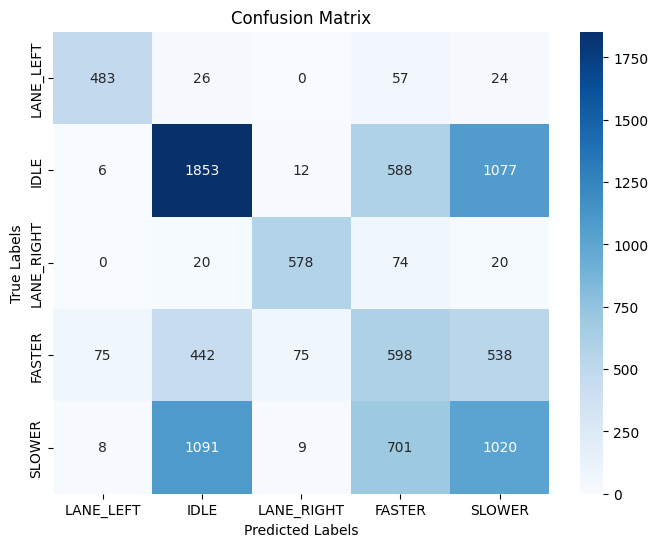

In [12]:
if train == TrainEnum.BC:
    env = make_configure_env(**env_kwargs)
    state_dim = env.observation_space.high.shape[0]*env.observation_space.high.shape[1]
    action_dim = env.action_space.n

    num_epochs = 3
    rng=np.random.default_rng()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    policy = DefaultActorCriticPolicy(env, device)
    
    batch_size= 128
    bc_trainer = bc.BC(
                        observation_space=env.observation_space,
                        action_space=env.action_space,
                        demonstrations=None, #training_transitions,
                        rng=rng,
                        batch_size=batch_size,
                        device = device,
                        policy=policy
                        )

    
    # reward_before_training, std_reward_before_training = evaluate_policy(bc_trainer.policy, env, 10)
    # print(f"Reward before training: {reward_before_training}, std_reward_before_training: {std_reward_before_training}")

    # Extract the HDF5 files from the zip archive
    with zipfile.ZipFile(zip_filename, 'r') as archive:
        archive.extractall(extract_path)

    # Extract the names of the HDF5 files from the zip archive
    with zipfile.ZipFile(zip_filename, 'r') as archive:
        hdf5_train_file_names = [os.path.join(extract_path, name) 
                                    for name in archive.namelist() 
                                    if name.endswith('.h5') and "train" in name]
        hdf5_val_file_names = [os.path.join(extract_path, name) 
                                    for name in archive.namelist() 
                                    if name.endswith('.h5') and "val" in name]            

    # Create separate datasets for each HDF5 file
    train_datasets = [CustomDataset(hdf5_name, device) for hdf5_name in hdf5_train_file_names[:2]]
    # val_datasets = [CustomDataset(hdf5_name, device) for hdf5_name in hdf5_val_file_names]
    
    # custom_dataset = CustomDataset(expert_data_file, device=device)
    train_data_loaders = [DataLoader(
                                dataset, 
                                batch_size=batch_size, 
                                shuffle=True,
                                drop_last=True,
                                num_workers=n_cpu,
                                pin_memory=True
                            ) for dataset in train_datasets]
    
    

    for epoch in range(num_epochs):
        for data_loader in train_data_loaders:
            bc_trainer.set_demonstrations(data_loader)
            bc_trainer.train(n_epochs=1)
    # reward_after_training, std_reward_after_training = evaluate_policy(bc_trainer.policy, env, 10)
    # print(f"Reward after training: {reward_after_training}, std_reward_after_training: {std_reward_after_training}") 


    with wandb.init(
                        project="BC", 
                        # magic=True,
                    ) as run:
                    run.name = f"sweep_{month}{day}_{timenow()}"
                    # Log the model as an artifact in wandb
                    torch.save(bc_trainer, 'BC_agent.pth')            
                    artifact = wandb.Artifact("trained_model", type="model")
                    artifact.add_file("BC_agent.pth")
                    run.log_artifact(artifact)
    wandb.finish()

    true_labels = []
    predicted_labels = []
    # Iterate through the validation data and make predictions
    with torch.no_grad():
        for val_data_file in hdf5_val_file_names[:2]:
            val_obs, val_acts, val_dones = extract_post_processed_expert_data(val_data_file)
            predicted_labels.extend([bc_trainer.policy.predict(obs)[0] for obs in val_obs])
            true_labels.extend(val_acts)

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average=None)
    recall = recall_score(true_labels, predicted_labels, average=None)
    f1 = f1_score(true_labels, predicted_labels, average=None)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Print the metrics
    print("Accuracy:", accuracy, np.mean(accuracy))
    print("Precision:", precision, np.mean(precision))
    print("Recall:", recall, np.mean(recall))
    print("F1 Score:", f1, np.mean(f1))


    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        for val_data_file in hdf5_train_file_names[:2]:
            val_obs, val_acts, val_dones = extract_post_processed_expert_data(val_data_file)
            predicted_labels.extend([bc_trainer.policy.predict(obs)[0] for obs in val_obs])
            true_labels.extend(val_acts)

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average=None)
    recall = recall_score(true_labels, predicted_labels, average=None)
    f1 = f1_score(true_labels, predicted_labels, average=None)



    print("--------  Training data metrics for reference---------------")
    print("Accuracy:", accuracy, np.mean(accuracy))
    print("Precision:", precision,  np.mean(precision))
    print("Recall:", recall, np.mean(recall))
    print("F1 Score:", f1, np.mean(recall))


    plt.figure(figsize=(8, 6))
    class_labels = [ ACTIONS_ALL[idx] for idx in range(len(ACTIONS_ALL))]
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()